# Final Project Coursera
In this project I want to explore Naples City (Italy) in order to show it is a good City for an investment in hotels and restaurant.
The mayor is trying to relaunch the city. He is in charge from **Vedere Anno**. We had several events as **Coppa Devis da Vedere** , **La coppa America** 

__Let's first of all try to import data for boroughs and neighborhoods__

In [444]:
from bs4 import BeautifulSoup
import requests # library to handle requests
import html5lib #parser
import lxml

import pandas as pd ### library for manipulating data as dataframe

import functools as ft ## function tools for reduce command

import numpy as np ## numpy array

import matplotlib ## library for plotting 
import matplotlib.pyplot as plt ## plots
import matplotlib.cm as cm
import matplotlib.colors as colorslib
%matplotlib inline

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import shapefile

import seaborn as sns #plotting and statistics

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans # library for clustering

from io import StringIO
from folium import plugins

# Import dataframe for boroughs and neighborhoods


In [445]:
#scrape site
res_all = requests.get("https://it.wikipedia.org/wiki/Municipalit%C3%A0_di_Napoli")
soup_all = BeautifulSoup(res_all.content, features='html')

# convert in dataframe
table = soup_all.find_all('table')[0] 
df = pd.read_html(str(table))[0]
df


,Distretto,Superficie,Popolazione,Densità,Presidente,Quartieri,Mappa
0,Municipalità I,"8,80 km²",82 673,"9.553,07 ab./km²",Francesco de Giovanni di Santa Severina (Forza...,"Chiaia, Posillipo, San Ferdinando",NaN
1,Municipalità II,"4,56 km²",91 536,"20.073,68 ab./km²",Francesco Chirico,"Avvocata, Montecalvario, Pendino, Porto, Merca...",NaN
2,Municipalità III,"9,51 km²",103 633,"10.897,27 ab./km²",Ivo Poggiani (Lista DemA),"Stella, San Carlo all'Arena",NaN
3,Municipalità IV,"9,27 km²",96 078,"10.364,4 ab./km²",Giampiero Perrella,"San Lorenzo, Vicaria, Poggioreale, Zona Indust...",NaN
4,Municipalità V,"7,42 km²",119 978,"16 169,54 ab./km²",Paolo De Luca,"Vomero, Arenella",NaN
5,Municipalità VI,"19,28 km²",138 641,"7 190,92 ab./km²",Salvatore Boggia,"Ponticelli, Barra, San Giovanni a Teduccio",NaN
6,Municipalità VII,"10,26 km²",91 460,"8 914,23 ab./km²",Maurizio Moschetti,"Miano, Secondigliano, San Pietro a Patierno",NaN
7,Municipalità VIII,"17,45 km²",92 616,"5 307,51 ab./km²",Paipais Apostolos,"Piscinola, Marianella, Scampia, Chiaiano",NaN
8,Municipalità IX,"16,56 km²",106 299,"6 419,02 ab./km²",Lorenzo Giannalavigna (PD),"Soccavo, Pianura",NaN
9,Municipalità X,"14,16 km²",101 192,"7 416,38 ab./km²",Diego Civitillo,"Bagnoli, Fuorigrotta",NaN


# Import geospatial data for every borough
In the website scraped are not present the coordinates for every borough but you can find in the site for the specific borough. The site are always of same form, changing just the number of borough. In every site the coordinates are in 'span class = "geo"'. 

__In order To build the data frame let's do the following steps:__

1. take the base site type: "https://it.wikipedia.org/wiki/Municipalit%C3%A0_" + number + "_di_Napoli":

In [446]:
firstPartOfSite = "https://it.wikipedia.org/wiki/Municipalit%C3%A0_"
thirdPartOfSite = "_di_Napoli"

2. take the number of boroughs:

In [447]:
numberBoroughs = len(df)

3. %do for cycle for every borough building url and scraping site:

In [448]:
#latitude = [];
#longitude = [];
#for number in range(1, numberBoroughs+1): ### the right extreme of range is not inclusive
    ## Define url
#    url = firstPartOfSite + str(number) + thirdPartOfSite
    
    ## Scrape site
#    res_borough = requests.get(url)
#    soup_borough = BeautifulSoup(res_borough.content, features='html')
    
    ## Get Coordinates
#    coordinates = soup_borough.find_all('span', attrs={"class":"geo"})[0].text
#    latLong = [float(coord) for coord in (coordinates.split('; '))]
#    latitude.append(latLong[0])
#    longitude.append(latLong[1])

E' meglio estrarre i dati dei centri dei borough da QGIS


I confini sono stati scaricati dall'openData del comune di Napoli in formato shapefile. Gli shapefile contengono geometrie nello standard Well Known Text che descrive gli elementi di una mappa come Point, LineString, Polygon e collection omogenee di questi oggetti. Poiché nei dati del comune le geometrie erano poligonali, con il software opensource QGIS si è estratto da esse i boundary come LineString e si è creato un nuovo shapefile caricato su github. Si è imposto come sistema di riferimento il 4326, comunemente utilizzato per descrivere le coordinate nei sistemi GNSS. 

Come migliore approssimazione del centro di ogni municipalità si può considerare il centroide di ogni geometry estratto da qgis


In [449]:
points = []
fields = []
with shapefile.Reader("/Users/claudiocalamita/Desktop/My_Notebook/centroidi.shp") as sf_centroids:
    ### Get Geometries 
    shapes = sf_centroids.shapes()
    ## For every line
    for point in shapes:
        points.append(point.points)
    ##Get fields of shapefile  
    records = sf_centroids.records()
    fields = [num.NUMERO-1 for num in records]
    ## Extract longitude and latitude
    longitude = [p[0][0] for p in points]
    latitude = [p[0][1] for p in points]
    
    ## Use Dataframe to sort for municipality
    df_geo = pd.DataFrame(list(zip(fields, longitude, latitude)), 
               columns =['Municipality', 'longitude', 'latitude']) 
    df_geo = df_geo.sort_values(by=['Municipality'])
    df_geo.reset_index(drop=True, inplace=True)

# Build DataFrame 

In [450]:
df.drop(columns=['Presidente', 'Mappa'], inplace=True)

In [451]:
## Rename
df.columns = ['Municipality', 'Surface_km2', 'Population', 'Density_per_km2', 'Neighborhood']

## Modify Municipality
df['Municipality'] = df['Municipality'].str.replace(" ", "_")

## Modify Surface
surface_numpy = df['Surface_km2'].to_numpy()
df['Surface_km2'] = [float(num.split()[0].replace(",",".")) for num in surface_numpy]

## Modify Population
population_numpy = df['Population'].to_numpy()
df['Population'] = [float(ft.reduce(lambda x, y: x + y, num.split())) for num in population_numpy]

## Modify Density
df['Density_per_km2'] = np.around(np.divide(df['Population'].to_numpy(), df['Surface_km2'].to_numpy()), decimals = 2)

## Add numbers of Neighborhoods for descritive analyses
neighborhood_numpy = df['Neighborhood'].to_numpy()
number_Neighborhoods = [neigh.split(',') for neigh in neighborhood_numpy]
number_Neighborhoods = [len(a) for a in number_Neighborhoods]
df['number_Neighborhoods'] = number_Neighborhoods
 
## Add Latitude and Longitude
df['Latitude'] = df_geo['latitude']
df['Longitude'] = df_geo['longitude']

In [452]:
df

,Municipality,Surface_km2,Population,Density_per_km2,Neighborhood,number_Neighborhoods,Latitude,Longitude
0,Municipalità_I,8.80,82673.0,9394.66,"Chiaia, Posillipo, San Ferdinando",3,40.820982,14.216484
1,Municipalità_II,4.56,91536.0,20073.68,"Avvocata, Montecalvario, Pendino, Porto, Merca...",6,40.849405,14.251298
2,Municipalità_III,9.51,103633.0,10897.27,"Stella, San Carlo all'Arena",2,40.870012,14.252006
3,Municipalità_IV,9.27,96078.0,10364.40,"San Lorenzo, Vicaria, Poggioreale, Zona Indust...",4,40.858170,14.281485
4,Municipalità_V,7.42,119978.0,16169.54,"Vomero, Arenella",2,40.853001,14.216932
5,Municipalità_VI,19.28,138641.0,7190.92,"Ponticelli, Barra, San Giovanni a Teduccio",3,40.850560,14.321321
6,Municipalità_VII,10.26,91460.0,8914.23,"Miano, Secondigliano, San Pietro a Patierno",3,40.889037,14.271280
7,Municipalità_VIII,17.45,92616.0,5307.51,"Piscinola, Marianella, Scampia, Chiaiano",4,40.889362,14.226583
8,Municipalità_IX,16.56,106299.0,6419.02,"Soccavo, Pianura",2,40.852707,14.176829
9,Municipalità_X,14.16,101192.0,7146.33,"Bagnoli, Fuorigrotta",2,40.820315,14.178860


# Plotting Boroughs on map

In [453]:
# Initialize a map
### Use geopy to extract a coordinate for Naples address 
address = 'Napoli, Na'

geolocator = Nominatim(user_agent="my_explorer", timeout=10)

location = geolocator.geocode(address)
latAddress = location.latitude
longAddress = location.longitude

print('The geograpical coordinate of Naples are {}, {}.'.format(latAddress, longAddress))

The geograpical coordinate of Naples are 40.8359336, 14.2487826.


In [454]:
# create map of Naples using latitude and longitude values
map_naples = folium.Map(location=[latAddress, longAddress], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Municipality'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_naples)  

## Add boundaries
with shapefile.Reader("/Users/claudiocalamita/Desktop/My_Notebook/confini.shp") as sf_boundary: ## sarà da fare un import su github
    ### Get Geometries 
    shapes = sf_boundary.shapes()
    ## For every line
    for line in shapes:
        listPoints = line.points
        newListPoints = []
        for p in listPoints:
            tuplePoint = (p[1], p[0])
            newListPoints.append(tuplePoint)
        folium.PolyLine(newListPoints).add_to(map_naples)

map_naples    

## Let's import shapefile

# Analisi descrittiva del dataframe

In [455]:
df.describe()

,Surface_km2,Population,Density_per_km2,number_Neighborhoods,Latitude,Longitude
count,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000
mean,11.727000,102410.60000,10187.756000,3.100000,40.855355,14.239308
std,4.838106,16340.59621,4625.415132,1.286684,0.023556,0.045428
min,4.560000,82673.00000,5307.510000,2.000000,40.820315,14.176829
25%,8.917500,91806.00000,7157.477500,2.000000,40.849694,14.216596
50%,9.885000,98635.00000,9154.445000,3.000000,40.852854,14.238940
75%,15.960000,105632.50000,10764.052500,3.750000,40.867051,14.266462
max,19.280000,138641.00000,20073.680000,6.000000,40.889362,14.321321


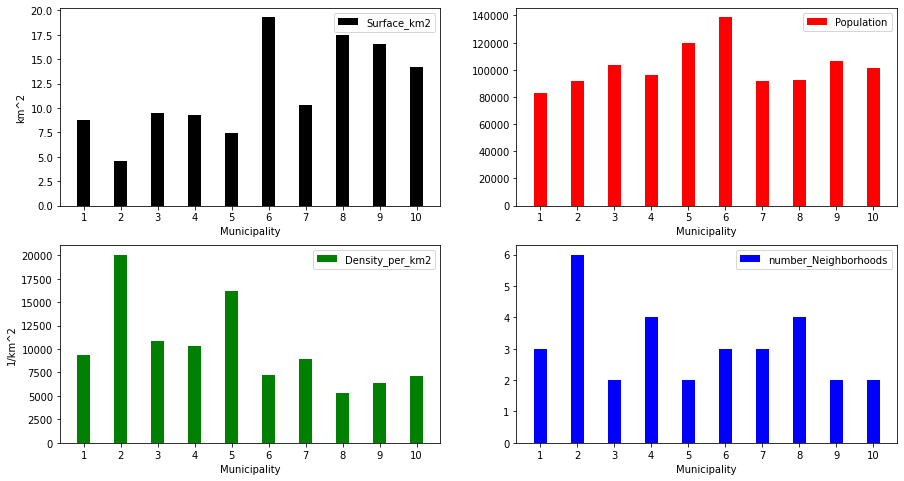

In [456]:
## Bar Plot
x = np.arange(1, len(df)+1)  # the label locations

width = 0.35  # the width of the bars

fig, axs = plt.subplots(2,2) ## Create a figure and a set of sublots
fig.set_size_inches(15, 8)
colors = ['black', 'red', 'green', 'blue']

# Plot Surface
axs[0,0].bar(x, df['Surface_km2'].to_numpy(), width, label='Surface_km2', color = colors[0])

axs[0,0].set_xlabel('Municipality')
axs[0,0].set_xticks(x)
axs[0,0].set_ylabel('km^2')
axs[0,0].legend()

# Plot Population
axs[0,1].bar(x, df['Population'].to_numpy(), width, label='Population', color = colors[1])

axs[0,1].set_xlabel('Municipality')
axs[0,1].set_xticks(x)
axs[0,1].legend()

# Plot Density
axs[1,0].bar(x, df['Density_per_km2'].to_numpy(), width, label='Density_per_km2', color = colors[2])

axs[1,0].set_xlabel('Municipality')
axs[1,0].set_xticks(x)
axs[1,0].set_ylabel('1/km^2')
axs[1,0].legend()

# Plot Number Neighborhood
axs[1,1].bar(x, df['number_Neighborhoods'].to_numpy(), width, label='number_Neighborhoods', color = colors[3])
axs[1,1].set_xlabel('Municipality')
axs[1,1].set_xticks(x)
axs[1,1].legend()


We can note that population is concentrated primarly in municipality with lower surface. So in this area there is a greater density of population and a greater number of neighborhoods (*second municipality shows 6 neighborhoods and ~20000 people per squared kilometer*)

_Let's see some scatter to better highlight these features_


Text(0, 0.5, 'Population')

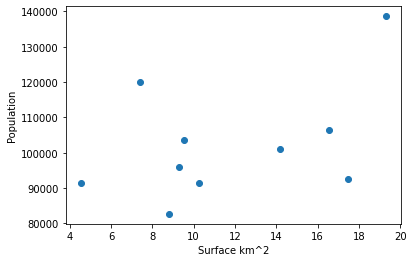

In [457]:
plt.scatter(df['Surface_km2'], df['Population'])
plt.xlabel('Surface km^2')
plt.ylabel('Population')

There is a net separation at 12 squared kilometers. Let's count the overall population at this cut value

In [458]:
dfLower = df[df['Surface_km2']<12]
populationLower = dfLower['Population'].sum()

dfUpper = df[df['Surface_km2']>12]
populationUpper = dfUpper['Population'].sum()

print("Population with in municipality with Surface lower than 12 squared kilometers: %d" % populationLower)
print("Population with in municipality with Surface greater than 12 squared kilometers: %d" % populationUpper)


Population with in municipality with Surface lower than 12 squared kilometers: 585358
Population with in municipality with Surface greater than 12 squared kilometers: 438748


Text(0, 0.5, 'Population')

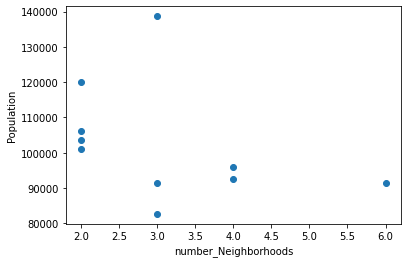

In [459]:
plt.scatter(df['number_Neighborhoods'], df['Population'])
plt.xlabel('number_Neighborhoods')
plt.ylabel('Population')

The population is primarly concentrated in municipality with low number of Neighborhoods

Text(0, 0.5, 'Surface_km2')

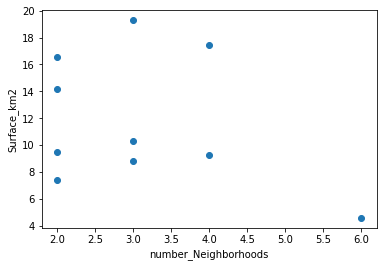

In [460]:
plt.scatter(df['number_Neighborhoods'], df['Surface_km2'])
plt.xlabel('number_Neighborhoods')
plt.ylabel('Surface_km2')

# Si prova ad estrarre i dati relativi alla temperatura

In [461]:
## Define url
url = "https://en.climate-data.org/europe/italy/campania/naples-4561/"
    
## Scrape site
res_temperature = requests.get(url)
soup_temperature = BeautifulSoup(res_temperature.content, features='html')

## extract wiki table
table_temp = soup_temperature.find_all('table', attrs={"id":"weather_table"}) ## la table è unica

df_temp = pd.read_html(str(table_temp))[0]
df_temp = df_temp.transpose()
df_temp = df_temp.reset_index()
df_temp.drop(0, inplace = True)
df_temp = df_temp.reset_index(drop=True)
df_temp.columns = ["Month","AvgTemp_C", "MinTemp_C", "MaxTemp_C", "AvgTemp_F", "MinTemp_F", "MaxTemp_F", "Rainfall_mm"]## rename columns
df_temp[["AvgTemp_C", "MinTemp_C", "MaxTemp_C", "AvgTemp_F", "MinTemp_F", "MaxTemp_F", "Rainfall_mm"]] = df_temp[["AvgTemp_C", "MinTemp_C", "MaxTemp_C", "AvgTemp_F", "MinTemp_F", "MaxTemp_F", "Rainfall_mm"]].astype(float) ## convert numerical values to float
df_temp

,Month,AvgTemp_C,MinTemp_C,MaxTemp_C,AvgTemp_F,MinTemp_F,MaxTemp_F,Rainfall_mm
0,January,8.6,4.9,12.4,47.5,40.8,54.3,100.0
1,February,9.2,5.2,13.2,48.6,41.4,55.8,84.0
2,March,10.9,6.7,15.1,51.6,44.1,59.2,76.0
3,April,13.3,8.9,17.8,55.9,48.0,64.0,68.0
4,May,17.2,12.5,22.0,63.0,54.5,71.6,44.0
5,June,21.0,16.0,26.0,69.8,60.8,78.8,29.0
6,July,23.3,18.1,28.6,73.9,64.6,83.5,21.0
7,August,23.6,18.3,29.0,74.5,64.9,84.2,37.0
8,September,21.0,16.2,25.9,69.8,61.2,78.6,71.0
9,October,17.0,12.6,21.5,62.6,54.7,70.7,112.0


Text(0, 0.5, 'Rainfall (mm)')

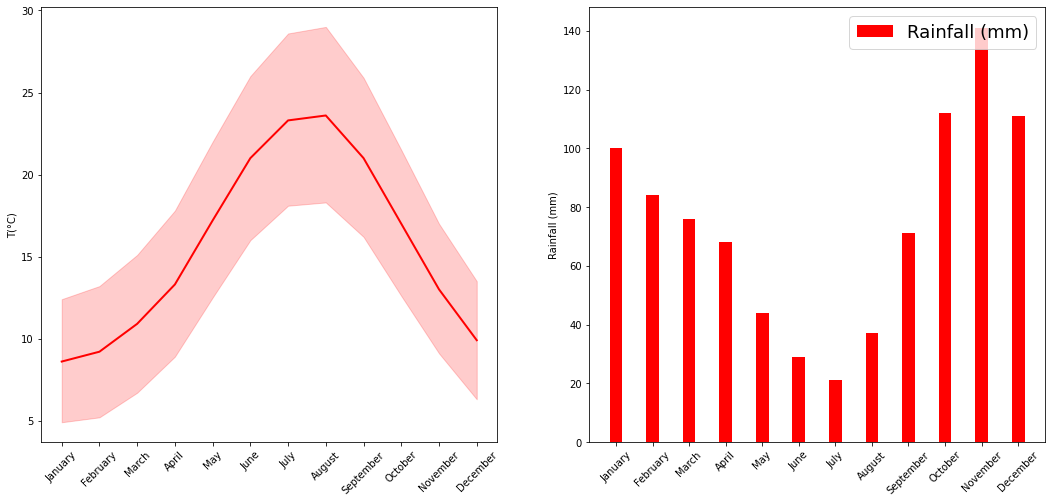

In [462]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
#LinePlot
ax1.plot(df_temp["Month"],df_temp["AvgTemp_C"], 'red', linewidth=2.0)
ax1.fill_between(df_temp["Month"], df_temp["MinTemp_C"], df_temp["MaxTemp_C"], alpha=0.2, color="red")
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel("T(°C)")

#BarPlot
ax2.bar(df_temp["Month"], df_temp["Rainfall_mm"], 0.35, label='Rainfall (mm)', color="red")
ax2.tick_params(axis='x', rotation=45)
ax2.legend(loc='upper right', fontsize = 18)
ax2.set_ylabel("Rainfall (mm)")

# Giusto per fare anche un confronto con New York per avere una idea

In [463]:
## Define url
url_nk = "https://en.climate-data.org/north-america/united-states-of-america/new-york/new-york-1091/"
    
## Scrape site
res_temperature_nk = requests.get(url_nk)
soup_temperature_nk = BeautifulSoup(res_temperature_nk.content, features='html5')

## extract wiki table
table_temp_nk = soup_temperature_nk.find_all('table', attrs={"id":"weather_table"}) ## la table è unica

df_temp_nk = pd.read_html(str(table_temp_nk))[0]
df_temp_nk = df_temp_nk.transpose()
df_temp_nk = df_temp_nk.reset_index()
df_temp_nk.drop(0, inplace = True)
df_temp_nk.columns = ["Month","AvgTemp_C", "MinTemp_C", "MaxTemp_C", "AvgTemp_F", "MinTemp_F", "MaxTemp_F", "Rainfall_mm"]## rename columns
df_temp_nk[["AvgTemp_C", "MinTemp_C", "MaxTemp_C", "AvgTemp_F", "MinTemp_F", "MaxTemp_F", "Rainfall_mm"]] = df_temp_nk[["AvgTemp_C", "MinTemp_C", "MaxTemp_C", "AvgTemp_F", "MinTemp_F", "MaxTemp_F", "Rainfall_mm"]].astype(float) ## convert numerical values to float


Text(0, 0.5, 'Rainfall (mm)')

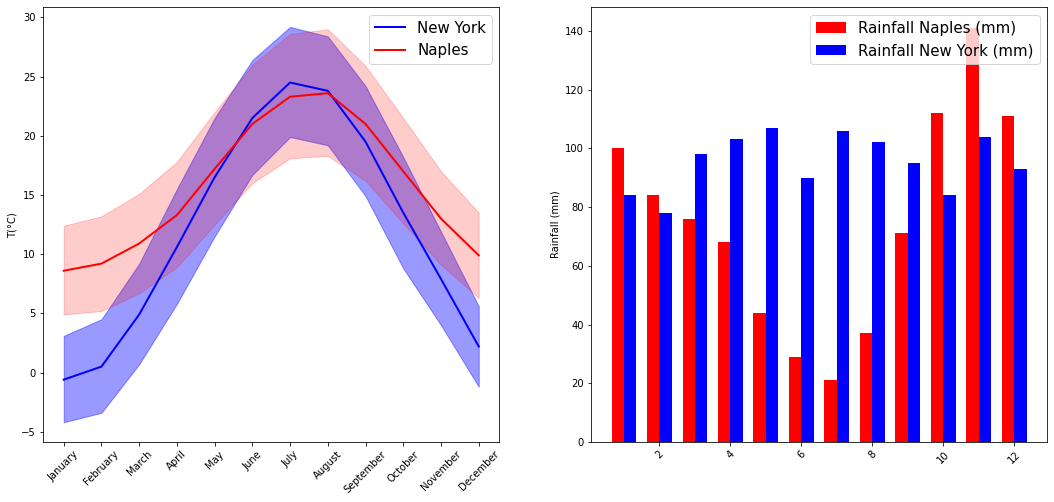

In [464]:
fig,(ax3, ax4) = plt.subplots(1, 2, figsize=(18, 8))
x = np.arange(1, 13)  # the label locations

#LinePlot
ax3.plot(df_temp_nk["Month"],df_temp_nk["AvgTemp_C"], 'blue', linewidth=2.0)
ax3.fill_between(df_temp_nk["Month"], df_temp_nk["MinTemp_C"], df_temp_nk["MaxTemp_C"], alpha=0.4, color="blue")

ax3.plot(df_temp["Month"], df_temp["AvgTemp_C"], 'red', linewidth=2.0)
ax3.fill_between(df_temp["Month"], df_temp["MinTemp_C"], df_temp["MaxTemp_C"], alpha=0.2, color="red")

ax3.tick_params(axis='x', rotation=45)
ax3.set_ylabel("T(°C)")
ax3.legend(["New York", "Naples"], fontsize = 15)

#BarPlot
width = 0.35
ax4.bar(x - width/2, df_temp["Rainfall_mm"], 0.35, label='Rainfall Naples (mm)', color="red")
ax4.bar(x + width/2, df_temp_nk["Rainfall_mm"], 0.35, label='Rainfall New York (mm)', color="blue")

ax4.tick_params(axis='x', rotation=45)

ax4.legend(loc='upper right', fontsize = 15)
ax4.set_ylabel("Rainfall (mm)")

## Nella prossima sezione si vedrà l'applicazione di Foursquare API per estrarre i locali presenti in ogni sezione 

In [465]:
# @hidden_cell
CLIENT_ID = 'SJVYFAOYIMC1JV4K5TXAO5C5DR2GEJPYNVQ00JEJEFRNIF1L' #  Foursquare ID
CLIENT_SECRET = 'SKTMQ0K2AKDPS5FFWFC5K4VUZZXSEKTR12D555T2LB1NORXT' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version

**Let's explore the first Neighborhood in the dataframe**

In [466]:
neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Chiaia, Posillipo, San Ferdinando are 40.82098174157186, 14.216483852161412.


#### Now, let's get the top 100 venues that are in The Beaches within a radius of 500 meters.

## First, let's create the GET request URL


In [467]:
LIMIT = 1000000 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

## Do request
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e79e370be61c9001cc15db1'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 35,
  'suggestedBounds': {'ne': {'lat': 40.829981750571875,
    'lng': 14.228354532081799},
   'sw': {'lat': 40.81198173257185, 'lng': 14.204613172241025}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5967c443a9e40247a73a45d9',
       'name': 'Ristorante Palazzo Petrucci',
       'location': {'lat': 40.821117,
        'lng': 14.214374,
        'labeledLatLngs': [{'label': 'display',
          'lat': 40.821117,
          'lng': 14.214374}],
      

The interesting information is contained in the items category

In [468]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [469]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Ristorante Palazzo Petrucci,Restaurant,40.821117,14.214374
1,Lido Sirena,Beach,40.818963,14.214102
2,Il Miracolo Dei Pesci,Restaurant,40.823293,14.217894
3,Pausilya,Spa,40.821116,14.214255
4,Chalet Ciro,Café,40.826210,14.219770


## Explore Neighborhoods in Naples

#### Let's create a function to repeat the same process of the previous section to all the neighborhoods in Naples


In [470]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT = 150):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now run the above function on each neighborhood and create a new dataframe called *naples_venues*.

In [471]:
naples_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [472]:
naples_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Chiaia, Posillipo, San Ferdinando",40.820982,14.216484,Ristorante Palazzo Petrucci,40.821117,14.214374,Restaurant
1,"Chiaia, Posillipo, San Ferdinando",40.820982,14.216484,Lido Sirena,40.818963,14.214102,Beach
2,"Chiaia, Posillipo, San Ferdinando",40.820982,14.216484,Il Miracolo Dei Pesci,40.823293,14.217894,Restaurant
3,"Chiaia, Posillipo, San Ferdinando",40.820982,14.216484,Belvedere Sant'Antonio a Posillipo,40.828133,14.218214,Scenic Lookout
4,"Chiaia, Posillipo, San Ferdinando",40.820982,14.216484,Chalet Ciro,40.826210,14.219770,Café
...,...,...,...,...,...,...,...
381,"Bagnoli, Fuorigrotta",40.820315,14.178860,Hotel Terme di Agnano,40.827031,14.170536,Hotel
382,"Bagnoli, Fuorigrotta",40.820315,14.178860,Cumana Bagnoli (L7),40.815320,14.166988,Light Rail Station
383,"Bagnoli, Fuorigrotta",40.820315,14.178860,Furgoncini fuori allo stadio solo durante le p...,40.822081,14.192249,Food Truck
384,"Bagnoli, Fuorigrotta",40.820315,14.178860,Ristorante Le due Palme,40.828401,14.169213,Restaurant


Let's check how many venues were returned for each neighborhood

In [473]:
naples_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Avvocata, Montecalvario, Pendino, Porto, Mercato, San Giuseppe",100,100,100,100,100,100
"Bagnoli, Fuorigrotta",46,46,46,46,46,46
"Chiaia, Posillipo, San Ferdinando",52,52,52,52,52,52
"Miano, Secondigliano, San Pietro a Patierno",8,8,8,8,8,8
"Piscinola, Marianella, Scampia, Chiaiano",8,8,8,8,8,8
"Ponticelli, Barra, San Giovanni a Teduccio",5,5,5,5,5,5
"San Lorenzo, Vicaria, Poggioreale, Zona Industriale",54,54,54,54,54,54
"Soccavo, Pianura",6,6,6,6,6,6
"Stella, San Carlo all'Arena",26,26,26,26,26,26


##  Analyze Each Neighborhood

In [474]:
# one hot encoding
naples_onehot = pd.get_dummies(naples_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
naples_onehot['Neighborhood'] = naples_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [naples_onehot.columns[-1]] + list(naples_onehot.columns[:-1])
naples_onehot = naples_onehot[fixed_columns]

naples_onehot.tail()

,Neighborhood,Art Museum,Bakery,Bar,Basketball Stadium,Beach,Bed & Breakfast,Beer Store,Bistro,Bookstore,...,Sushi Restaurant,Theater,Toy / Game Store,Trail,Train Station,Trattoria/Osteria,Travel Agency,Wine Bar,Yoga Studio,Zoo
381,"Bagnoli, Fuorigrotta",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
382,"Bagnoli, Fuorigrotta",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
383,"Bagnoli, Fuorigrotta",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
384,"Bagnoli, Fuorigrotta",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
385,"Bagnoli, Fuorigrotta",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [475]:
naples_grouped = naples_onehot.groupby('Neighborhood').mean().reset_index()
naples_grouped

,Neighborhood,Art Museum,Bakery,Bar,Basketball Stadium,Beach,Bed & Breakfast,Beer Store,Bistro,Bookstore,...,Sushi Restaurant,Theater,Toy / Game Store,Trail,Train Station,Trattoria/Osteria,Travel Agency,Wine Bar,Yoga Studio,Zoo
0,"Avvocata, Montecalvario, Pendino, Porto, Merca...",0.03,0.000000,0.02,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,...,0.000000,0.010000,0.000000,0.01,0.000000,0.040000,0.000000,0.01,0.000,0.000000
1,"Bagnoli, Fuorigrotta",0.00,0.021739,0.00,0.021739,0.000000,0.000000,0.000000,0.021739,0.000000,...,0.021739,0.021739,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000,0.021739
2,"Chiaia, Posillipo, San Ferdinando",0.00,0.000000,0.00,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,...,0.019231,0.000000,0.000000,0.00,0.019231,0.000000,0.000000,0.00,0.000,0.000000
3,"Miano, Secondigliano, San Pietro a Patierno",0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.125,0.000000
4,"Piscinola, Marianella, Scampia, Chiaiano",0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.125000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000,0.000000
5,"Ponticelli, Barra, San Giovanni a Teduccio",0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.200000,0.000000,0.000000,0.00,0.000,0.000000
6,"San Lorenzo, Vicaria, Poggioreale, Zona Indust...",0.00,0.018519,0.00,0.000000,0.000000,0.055556,0.000000,0.000000,0.018519,...,0.000000,0.000000,0.000000,0.00,0.018519,0.000000,0.000000,0.00,0.000,0.000000
7,"Soccavo, Pianura",0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000,0.000000
8,"Stella, San Carlo all'Arena",0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.038462,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000,0.000000
9,"Vomero, Arenella",0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.012346,0.000000,0.000000,...,0.012346,0.024691,0.012346,0.00,0.000000,0.012346,0.012346,0.00,0.000,0.000000


#### Let's print each neighborhood along with the top 5 most common venues

In [476]:
num_top_venues = 5

for hood in naples_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = naples_grouped[naples_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Avvocata, Montecalvario, Pendino, Porto, Mercato, San Giuseppe----
           venue  freq
0    Pizza Place  0.22
1          Plaza  0.09
2  Historic Site  0.08
3           Café  0.07
4          Hotel  0.07


----Bagnoli, Fuorigrotta----
                venue  freq
0               Hotel  0.20
1  Italian Restaurant  0.07
2                Café  0.04
3  Light Rail Station  0.04
4         Pizza Place  0.04


----Chiaia, Posillipo, San Ferdinando----
         venue  freq
0  Pizza Place  0.17
1   Restaurant  0.12
2         Café  0.12
3          Pub  0.06
4    Cable Car  0.04


----Miano, Secondigliano, San Pietro a Patierno----
         venue  freq
0  Pizza Place  0.25
1        Hotel  0.25
2  Yoga Studio  0.12
3        Plaza  0.12
4         Park  0.12


----Piscinola, Marianella, Scampia, Chiaiano----
                venue  freq
0       Metro Station  0.38
1  Italian Restaurant  0.12
2       Memorial Site  0.12
3         Pizza Place  0.12
4             Theater  0.12


----Ponticelli, Barra

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [477]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [478]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = naples_grouped['Neighborhood']

for ind in np.arange(naples_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(naples_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Avvocata, Montecalvario, Pendino, Porto, Merca...",Pizza Place,Plaza,Historic Site,Italian Restaurant,Café,Hotel,Trattoria/Osteria,Ice Cream Shop,Castle,Dessert Shop
1,"Bagnoli, Fuorigrotta",Hotel,Italian Restaurant,Pizza Place,Café,Light Rail Station,Plaza,Park,Nightclub,Music Venue,Multiplex
2,"Chiaia, Posillipo, San Ferdinando",Pizza Place,Café,Restaurant,Pub,Plaza,Cable Car,Seafood Restaurant,Beach,Ice Cream Shop,Hotel
3,"Miano, Secondigliano, San Pietro a Patierno",Hotel,Pizza Place,Café,Park,Plaza,Yoga Studio,Historic Site,Gym / Fitness Center,Diner,Dive Bar
4,"Piscinola, Marianella, Scampia, Chiaiano",Metro Station,Italian Restaurant,Pizza Place,Memorial Site,Theater,Park,Food Truck,Diner,Dive Bar,Fast Food Restaurant
5,"Ponticelli, Barra, San Giovanni a Teduccio",Ice Cream Shop,Intersection,Light Rail Station,Train Station,Café,Garden,Diner,Dive Bar,Fast Food Restaurant,Fish & Chips Shop
6,"San Lorenzo, Vicaria, Poggioreale, Zona Indust...",Pizza Place,Hotel,Italian Restaurant,Bed & Breakfast,Dessert Shop,Plaza,Food,Candy Store,Clothing Store,Rental Car Location
7,"Soccavo, Pianura",Hotel,Café,Pizza Place,Light Rail Station,Gym,Outdoors & Recreation,Diner,Dive Bar,Fast Food Restaurant,Fish & Chips Shop
8,"Stella, San Carlo all'Arena",Pizza Place,Hotel,Historic Site,Café,Park,Gym,Garden,Museum,Fast Food Restaurant,Dessert Shop
9,"Vomero, Arenella",Pizza Place,Café,Gastropub,Plaza,Pub,Sandwich Place,Ice Cream Shop,Dessert Shop,Theater,Coffee Shop


# Cluster Neighborhoods

## After superimposed Data on map let's define the number of cluster

Text(0.5, 1.0, 'Elbow Method For Optimal k')

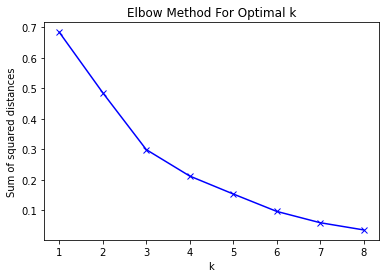

In [479]:
## Calculate besk K
naples_grouped_clustering = naples_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1,9)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(naples_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

## Plot k and range
fig, plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')


In [480]:
# The optimal cut is for k = 
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(naples_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 1, 3, 0, 2, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [481]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

naples_merged = df

# merge naples_grouped with naples_data to add latitude/longitude for each neighborhood
naples_merged = naples_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

naples_merged.head() # check the last columns!

,Municipality,Surface_km2,Population,Density_per_km2,Neighborhood,number_Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Municipalità_I,8.80,82673.0,9394.66,"Chiaia, Posillipo, San Ferdinando",3,40.820982,14.216484,0,Pizza Place,Café,Restaurant,Pub,Plaza,Cable Car,Seafood Restaurant,Beach,Ice Cream Shop,Hotel
1,Municipalità_II,4.56,91536.0,20073.68,"Avvocata, Montecalvario, Pendino, Porto, Merca...",6,40.849405,14.251298,0,Pizza Place,Plaza,Historic Site,Italian Restaurant,Café,Hotel,Trattoria/Osteria,Ice Cream Shop,Castle,Dessert Shop
2,Municipalità_III,9.51,103633.0,10897.27,"Stella, San Carlo all'Arena",2,40.870012,14.252006,0,Pizza Place,Hotel,Historic Site,Café,Park,Gym,Garden,Museum,Fast Food Restaurant,Dessert Shop
3,Municipalità_IV,9.27,96078.0,10364.40,"San Lorenzo, Vicaria, Poggioreale, Zona Indust...",4,40.858170,14.281485,0,Pizza Place,Hotel,Italian Restaurant,Bed & Breakfast,Dessert Shop,Plaza,Food,Candy Store,Clothing Store,Rental Car Location
4,Municipalità_V,7.42,119978.0,16169.54,"Vomero, Arenella",2,40.853001,14.216932,0,Pizza Place,Café,Gastropub,Plaza,Pub,Sandwich Place,Ice Cream Shop,Dessert Shop,Theater,Coffee Shop


In [482]:
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,"Avvocata, Montecalvario, Pendino, Porto, Merca...",Pizza Place,Plaza,Historic Site,Italian Restaurant,Café,Hotel,Trattoria/Osteria,Ice Cream Shop,Castle,Dessert Shop
1,0,"Bagnoli, Fuorigrotta",Hotel,Italian Restaurant,Pizza Place,Café,Light Rail Station,Plaza,Park,Nightclub,Music Venue,Multiplex
2,0,"Chiaia, Posillipo, San Ferdinando",Pizza Place,Café,Restaurant,Pub,Plaza,Cable Car,Seafood Restaurant,Beach,Ice Cream Shop,Hotel
3,0,"Miano, Secondigliano, San Pietro a Patierno",Hotel,Pizza Place,Café,Park,Plaza,Yoga Studio,Historic Site,Gym / Fitness Center,Diner,Dive Bar
4,1,"Piscinola, Marianella, Scampia, Chiaiano",Metro Station,Italian Restaurant,Pizza Place,Memorial Site,Theater,Park,Food Truck,Diner,Dive Bar,Fast Food Restaurant
5,3,"Ponticelli, Barra, San Giovanni a Teduccio",Ice Cream Shop,Intersection,Light Rail Station,Train Station,Café,Garden,Diner,Dive Bar,Fast Food Restaurant,Fish & Chips Shop
6,0,"San Lorenzo, Vicaria, Poggioreale, Zona Indust...",Pizza Place,Hotel,Italian Restaurant,Bed & Breakfast,Dessert Shop,Plaza,Food,Candy Store,Clothing Store,Rental Car Location
7,2,"Soccavo, Pianura",Hotel,Café,Pizza Place,Light Rail Station,Gym,Outdoors & Recreation,Diner,Dive Bar,Fast Food Restaurant,Fish & Chips Shop
8,0,"Stella, San Carlo all'Arena",Pizza Place,Hotel,Historic Site,Café,Park,Gym,Garden,Museum,Fast Food Restaurant,Dessert Shop
9,0,"Vomero, Arenella",Pizza Place,Café,Gastropub,Plaza,Pub,Sandwich Place,Ice Cream Shop,Dessert Shop,Theater,Coffee Shop


# Plotting clusters on Map

In [483]:
# create map
map_clusters = folium.Map(location=[latAddress, longAddress], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colorslib.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(naples_merged['Latitude'], naples_merged['Longitude'], naples_merged['Neighborhood'], naples_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_naples)
       
map_naples

# Una prossima idea potrebbe ssere quella di analizzare ogni cluster, capire quelli più interessanti per certe caratteristiche. 

# cluster 1

In [484]:
naples_merged.loc[naples_merged['Cluster Labels'] == 0, naples_merged.columns[[1] + list(range(5, naples_merged.shape[1]))]]

,Surface_km2,number_Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,8.80,3,40.820982,14.216484,0,Pizza Place,Café,Restaurant,Pub,Plaza,Cable Car,Seafood Restaurant,Beach,Ice Cream Shop,Hotel
1,4.56,6,40.849405,14.251298,0,Pizza Place,Plaza,Historic Site,Italian Restaurant,Café,Hotel,Trattoria/Osteria,Ice Cream Shop,Castle,Dessert Shop
2,9.51,2,40.870012,14.252006,0,Pizza Place,Hotel,Historic Site,Café,Park,Gym,Garden,Museum,Fast Food Restaurant,Dessert Shop
3,9.27,4,40.858170,14.281485,0,Pizza Place,Hotel,Italian Restaurant,Bed & Breakfast,Dessert Shop,Plaza,Food,Candy Store,Clothing Store,Rental Car Location
4,7.42,2,40.853001,14.216932,0,Pizza Place,Café,Gastropub,Plaza,Pub,Sandwich Place,Ice Cream Shop,Dessert Shop,Theater,Coffee Shop
6,10.26,3,40.889037,14.271280,0,Hotel,Pizza Place,Café,Park,Plaza,Yoga Studio,Historic Site,Gym / Fitness Center,Diner,Dive Bar
9,14.16,2,40.820315,14.178860,0,Hotel,Italian Restaurant,Pizza Place,Café,Light Rail Station,Plaza,Park,Nightclub,Music Venue,Multiplex


Cluster 1 is characterized by a place primarily for Reastaurant, fast food, cafe, ice cream shop. It is near the sea, and has a very great appeal for turism  

# Cluster 2

In [485]:
naples_merged.loc[naples_merged['Cluster Labels'] == 1, naples_merged.columns[[1] + list(range(5, naples_merged.shape[1]))]]

,Surface_km2,number_Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,17.45,4,40.889362,14.226583,1,Metro Station,Italian Restaurant,Pizza Place,Memorial Site,Theater,Park,Food Truck,Diner,Dive Bar,Fast Food Restaurant


# Cluster 3

In [486]:
naples_merged.loc[naples_merged['Cluster Labels'] == 2, naples_merged.columns[[1] + list(range(5, naples_merged.shape[1]))]]

,Surface_km2,number_Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,16.56,2,40.852707,14.176829,2,Hotel,Café,Pizza Place,Light Rail Station,Gym,Outdoors & Recreation,Diner,Dive Bar,Fast Food Restaurant,Fish & Chips Shop


# Cluster 4

In [487]:
naples_merged.loc[naples_merged['Cluster Labels'] == 3, naples_merged.columns[[1] + list(range(5, naples_merged.shape[1]))]]

,Surface_km2,number_Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,19.28,3,40.85056,14.321321,3,Ice Cream Shop,Intersection,Light Rail Station,Train Station,Café,Garden,Diner,Dive Bar,Fast Food Restaurant,Fish & Chips Shop


# Cluster 5

In [488]:
naples_merged.loc[naples_merged['Cluster Labels'] == 4, naples_merged.columns[[1] + list(range(5, naples_merged.shape[1]))]]

,Surface_km2,number_Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


# Vediamo di convergere


In [489]:
#scrape site
res_employ = requests.get("https://en.wikipedia.org/wiki/Naples")
soup_employ = BeautifulSoup(res_employ.content, features='html')

# convert in dataframe
table_employ = soup_employ.find_all('table', attrs={'class':'wikitable'})[4]
df_employ = pd.read_html(str(table_employ), flavor='bs4')[0]
df_employ

,Unnamed: 0,Public services,Manufacturing,Commerce,Construction,Transportation,Financial services,Agriculture,Hotel trade,Other activities
0,Percentage,30.7%,18%,14%,9.5%,8.2%,7.4%,5.1%,3.7%,3.4%


# Risultati

# Si potrebbe fare una density area per ogni attività, hotel, ristorante, pizza place
I cluster 1 e 5 sono quelli più periferici della città e sono rated principalmente per station or bakery
Il cluster 3 è più residenziale, con palestra, yoga, cafe, station, supermarket
cluster 2 è più rated per ristoranti, 
cluster 4 per hotel e pizza place ed è la zona del centro storico e di musei

# Feedback

In [513]:
def heatMapForCategory(search_query, LIMIT = 1000000, radius = 10000):
    # create map of Naples using latitude and longitude values
    heatmap = folium.Map(location=[latAddress, longAddress], zoom_start=12)

    url_category = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latAddress, longAddress, VERSION, search_query, radius, LIMIT)
    results = requests.get(url_category).json()
    
    # assign relevant part of JSON to venues
    venues = results['response']['venues']
    
    # tranform venues into a dataframe
    category_json = json_normalize(venues)
    category = category_json[['name', 'location.lat', 'location.lng']]

    # convert to (n, 2) nd-array format for heatmap
    stationArr = category[['location.lat', 'location.lng']].as_matrix()
    heatmap.add_children(plugins.HeatMap(stationArr, radius=20))
    
    
    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(naples_merged['Latitude'], naples_merged['Longitude'], naples_merged['Neighborhood'], naples_merged['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=10,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=1).add_to(heatmap)

    ## Add boundaries
    with shapefile.Reader("/Users/claudiocalamita/Desktop/My_Notebook/confini.shp") as sf_boundary: ## sarà da fare un import su github
        ### Get Geometries 
        shapes = sf_boundary.shapes()
        ## For every line
        for line in shapes:
            listPoints = line.points
            newListPoints = []
            for p in listPoints:
                tuplePoint = (p[1], p[0])
                newListPoints.append(tuplePoint)
            folium.PolyLine(newListPoints).add_to(heatmap)
            
    return heatmap

In [522]:
### Quello che voglio mostrare è che zone per aprire un hotel sono quelle del cluster 4, così anche il pizza place, mi aspetto una mappa più hot in queste zone
# Proviamo a fare una query su Fousquare per Hotel
search_query = "hotel"
heatMap_New_hotel = heatMapForCategory(search_query)

# Ora voglio mostrare un altro cluster per le pizzerie sempre in questa zona
search_query = "pizza"
heatMap_New_pizza = heatMapForCategory(search_query)

# Vediamo per le pizzerie
search_query = "restaurant"
heatMap_New_restaurant = heatMapForCategory(search_query)

# Vediamo per coffe
search_query = "coffe"
heatMap_New_coffe = heatMapForCategory(search_query)

# Vediamo per food
search_query = "food"
heatMap_New_food = heatMapForCategory(search_query)



/Users/claudiocalamita/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/Users/claudiocalamita/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:17: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [524]:
heatMap_New_hotel

In [525]:
 heatMap_New_pizza

In [526]:
heatMap_New_restaurant

In [527]:
heatMap_New_coffe

In [528]:
heatMap_New_food

### Sicuramente è da normalizzare la posizione dei centri perché in questo modo i cluster vengono alterati.
## E' da capire come normalizzare per cercare elementi solo all'interno del boundig box


# Non si può fare una deep copy di una map folium. L'unica cosa è avere una funzione che mi restituisce un elemento con i cluster